# Introduction to nonlinear elasticity: deflection of a heavy hyperelastic beam 

In this notebook we give an example for the solution of a problem of nonlinear elasticity.

We focus on the simple problem of a cantilever beam loaded only by its own weight.

We exploit `UFL` features for automatic symbolic differentiation and formulate the problem by writing the potential energy of the system. 

We will use here the FEniCS  build-in nonlinear Netwon solver to solve the problem.

We strongly suggest to read also the fully commented`FEniCS` demo on hypelasticity 
https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/hyperelasticity/demo_hyperelasticity.py.html.

The comments in this noteboook are complentary to those provided  in the FEniCS demo

## Basic import statements and parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import dolfin
import mshr
import ufl

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')
%matplotlib inline

## Problem and solver setting

Create a mesh and the `ds` measures with boundary indicators 

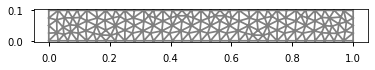

In [2]:
# Mesh

Lx, Ly = 1., .1
nx   = 20

p0   = dolfin.Point(0,0)
p1   = dolfin.Point(Lx,Ly)

geom = mshr.Rectangle(p0, p1)
mesh = mshr.generate_mesh(geom, nx)

# mesh = dolfin.RectangleMesh(p0, p1, nx, nx) #why is it any different

# Mark boundary subdomains
left   = dolfin.CompiledSubDomain("near(x[0],0)  && on_boundary")
right  = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary",Lx=Lx)
bottom = dolfin.CompiledSubDomain("near(x[1],0)  && on_boundary")
top    = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary",Ly=Ly)

# Mark facets for Neumann BCs
boundary_indices = {'left':   1,
                    'right':  2,
                    'top':    3,
                    'bottom': 4}

boundary_markers = dolfin.MeshFunction("size_t",
                                       mesh    ,
                                       dim=1   ,
                                       value=0 )

left.mark(  boundary_markers, boundary_indices["left"  ])
right.mark( boundary_markers, boundary_indices["right" ])
top.mark(   boundary_markers, boundary_indices["top"   ])
bottom.mark(boundary_markers, boundary_indices["bottom"])

# Redefine element of area to include information about the markers
ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)
dolfin.plot(mesh)

We save the markers in an XDMF file that can be opened in paraview.

In [3]:
with dolfin.XDMFFile("mesh_functions.xdmf") as f:
    f.write(boundary_markers)

 We define now the finite element space for the displacement u

In [4]:
V_element = dolfin.VectorElement('CG', ufl.triangle, degree=2) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")

 Let us introduce now some useful definition for the kinematics.
 These expresions are symbolic operators of UFL.
 At this level no computation is performed.

In [5]:
# Kinematics 
I  = ufl.Identity(2)    # Identity tensor
F  = ufl.variable(I + ufl.grad(u)) # u = displacement x - x_0  
C  = F.T*F                   

Ic = ufl.tr(C)
J  = ufl.det(F)

E  = 1/2*(C-I)
# Stored strain energy density (compressible neo-Hookean model)

# ------------

# Elasticity parameters (plane-stress)
Y, nu     = 1.e3, 0.3
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))

# line to redifine lambda if one considers plane strains/stresses
lmbda     = 2*lmbda*mu/(lmbda + 2*mu)

psi = lmbda*ufl.tr(E)**2/2+mu*ufl.inner(E,E) #==elastic energy with Hooke Law with eps=E

 We can have an automatic symbolic derivation of the strain energy density to define the First Piola-Kirchhoff stress 
 
 $${P}=\dfrac{\partial\Psi}{\partial F}$$
 
 To this end we use the `diff` operator of `UFL`(https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#variable-derivatives).
 
 Its use requires to define the symbol of the derivation variable as a `UFL` `variable`. 
 That is the reason why `F` in the preivous cell is defined as a `ufl.variable`.


In [6]:
P = ufl.diff(psi, F) 
n = dolfin.FacetNormal(mesh) # normal to the mesh

Hence, we can define the bulk force (`b0`) and surface traction (`g0`) and the total potential energy functional. in this example they are initially set to `0`.

In [7]:
b0 = dolfin.Expression(("0.0", "mu*t"), t=0, mu=mu, degree=0)  
g0 = mu*dolfin.Constant((0., 0.)) 

# Total potential energy
potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(boundary_indices['right'])

As a Dirichlet Boundary condition, we block the left-end

In [8]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)]

The variational problem to solve is the minimization of the potential energy with the given boundary conditions.

The problem is nonlinear and requires the use of a Newton solver. 

To this end we need to define the  *residual*, given by the first derivative of the energy, and the *Jacobian* (or *Hessian*), given by second directional derivative of the energy.

In FEniCS, thanks to the symbolic differentiation tools provided by `UFL` this can be done automatically, without effort from the user.

To this end we use the `derivative` function from `UFL` which allows us to calculate the directional derivative of a form.
We refer to the `UFL` manual for the syntax: https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#ad


In [9]:
# Compute first variation of the potential energy (directional derivative about u in the direction of v)
residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V)) #==eps' with eps the potential energy

# Compute Jacobian of the energy
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V)) #==eps'' with eps the potential energy

All the informations about the variational problem to be solved  (residual, jacobian, bcs, and indipendent variable) can be  collected in the dolfin class `NonlinearVariationalProblem` https://fenicsproject.org/docs/dolfin/2019.1.0/cpp/db/d3d/classdolfin_1_1NonlinearVariationalProblem.html

In [10]:
# Set the variational problem
problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)

We can define then a nonlinear solver class, provided by FEniCS.
This solver can implement the basic newton method or more complex nonlinear solvers (that we will not discuss in class).
A long list of parameters can be specified. 
All the nonlinear solver available in `PETSc` can be used. We suggest the reading of the PETSC user manual (Chapter 5, SNES Solver). 

In [11]:
# dolfin.PETScOptions.set("help",1)
solver = dolfin.NonlinearVariationalSolver(problem)
dolfin.info(solver.parameters, True)

#solver.parameters.update({"nonlinear_solver":"snes"})
#dolfin.PETScOptions.set("snes_type","newtonls")

## Solve the static nonlinear problem

We can now solve the problem. 
To start let us initialize the solution at $u=(0,0)$ and set vanishing loads


Text(0.5, 1.0, 'Solution with vanishing force converged with 0 iterations and reason 1')

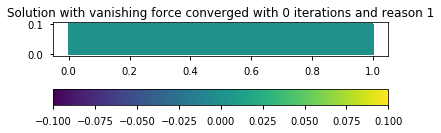

In [12]:
# Data
b0.t = 0.0 # no volumic force
u.interpolate(dolfin.Constant((0.,0.))) # initial guess

# Solve
niterations, reason = solver.solve()

# Display

plt.colorbar(dolfin.plot(u, mode="displacement"), orientation="horizontal")
plt.title("Solution with vanishing force converged with {:d} iterations and reason {:b}".format(niterations,reason))

Without surprise the solution is null because the loading is null.
The solver gives the output: the number of newton iterations required and the reason (`1`: converged, `0`: non-converged)

Let us increase sligtly the volume force. Always initializing at $u=(0,0)$. 

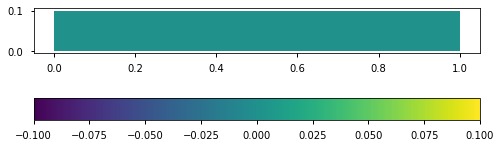

In [29]:
# Data
b0.t = -.001
u.interpolate(dolfin.Constant((0.,0.)))

# Solve
solver.solve()

# Display
plt.colorbar(dolfin.plot(u, mode="displacement"), orientation="horizontal")

We get a reasonable solution, showing the deflection of the beam under its own weight. 
As a quantitative output we can get the average displacement at the rigth end.


Notes on the `python` synthax used below:
- For string formatting syntax see https://pyformat.info/
- list comprehension to generate a vector https://www.datacamp.com/community/tutorials/python-list-comprehension
- We use `*` to unpack a list https://docs.python.org/2/tutorial/controlflow.html#unpacking-argument-lists


In [14]:
uR = [dolfin.assemble(u[i]*ds(2))/Ly for i in [0, 1]] # assemble==integral so we consider the value at right hand side (2nd edge) by calculating mean value.
print("The average displacement at the right end is u=({:.4f},{:.4f})".format(*uR))

The average displacement at the right end is u=(-0.0019,0.0580)


We can calculate the total reaction force at the left end to double-check against what we expect from global equilibrium:

In [15]:
fL = [dolfin.assemble((P*n)[i]*ds(1)) for i in [0, 1]]
fL_exact = [dolfin.assemble(b0[i]*dx) for i in [0, 1]]
print("The total reaction force at the left end is ({:.4f},{:.4f})".format(*fL))
print("The expected value is ({:+.4f},{:+.4f})".format(*fL_exact))

The total reaction force at the left end is (0.0186,-0.0367)
The expected value is (+0.0000,+0.0385)


The error is non-negligible. 
- Convergence toward the expected value can be obtained after mesh refinement or increasing the interpolation order of the basis functions. 
- You can check also that the error will be very relevant with linear elements. The presence of body loading render linear elements non optimal. Have you an explication for this fact? 

## Solve of a quasi-static evolution problem with continuation

Consider now to increment slowly the loading with time. 
We discretise the time in $n_t$ time-steps of equal length. 
At each time step $t_i$, the solution of the problem can be obtained by initializing the newton solver  with the solution of the previous time-step. This will greatly facilitate the convergence of the Newton algorithm. 

It sufficies to perform a `for` loop as follows. Note the initialization of the Newton algorithm at each time step is done with the latest solution available which is stored in memory.

For visualisation, we store the solution in an `XDMF` file, that we can open with `paraview`.


*Remark:* 
- The initialization of the solution before starting the solver is fundamental in nonlinear problems, because the solution can be not unique. 

- Smaller time-steps generally helps convergence. Nonlinear solves can not converge for large time-step because the initialization of the newton solver is not close enough to a possible solution.

- Newton solvers converge very quickly (quadratic convergence rate) when they are close to a possible solution of the system to solve. But they can stagnate or diverge is they are not correctly initialized. 

- You can monitor the interation of the Newton solver in the terminal window where you launched `jupyter`.

You can play to test these points


t=+0.000, u=+0.000
t=+0.001, u=-0.059
t=+0.002, u=-0.117
t=+0.003, u=-0.174
t=+0.004, u=-0.228
t=+0.005, u=-0.279
t=+0.006, u=-0.326
t=+0.007, u=-0.370
t=+0.008, u=-0.411
t=+0.009, u=-0.448
t=+0.010, u=-0.482
t=+0.011, u=-0.513
t=+0.012, u=-0.542
t=+0.013, u=-0.568
t=+0.014, u=-0.591
t=+0.015, u=-0.613
t=+0.016, u=-0.632
t=+0.017, u=-0.650
t=+0.018, u=-0.667
t=+0.019, u=-0.682
t=+0.020, u=-0.696
t=+0.021, u=-0.709
t=+0.022, u=-0.720
t=+0.023, u=-0.731
t=+0.024, u=-0.742
t=+0.026, u=-0.751
t=+0.027, u=-0.760
t=+0.028, u=-0.768
t=+0.029, u=-0.776
t=+0.030, u=-0.783
t=+0.031, u=-0.790
t=+0.032, u=-0.796
t=+0.033, u=-0.802
t=+0.034, u=-0.808
t=+0.035, u=-0.813
t=+0.036, u=-0.818
t=+0.037, u=-0.823
t=+0.038, u=-0.827
t=+0.039, u=-0.831
t=+0.040, u=-0.836
t=+0.041, u=-0.839
t=+0.042, u=-0.843
t=+0.043, u=-0.847
t=+0.044, u=-0.850
t=+0.045, u=-0.853
t=+0.046, u=-0.857
t=+0.047, u=-0.860
t=+0.048, u=-0.862
t=+0.049, u=-0.865
t=+0.050, u=-0.868


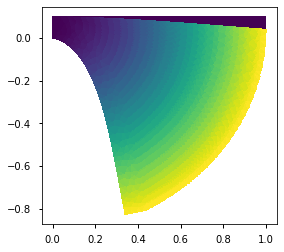

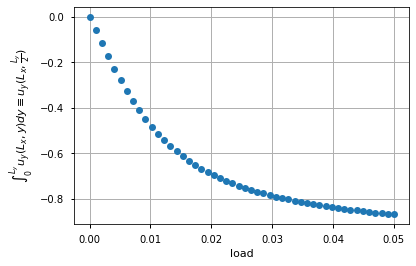

In [16]:
loads = np.linspace(0, .05, 50)
displ = np.zeros_like(loads)

u.interpolate(dolfin.Constant((0., 0.))) # initial guess

file_u = dolfin.XDMFFile("output/u.xdmf")
file_u.parameters.update({"flush_output": True,
                          "functions_share_mesh": True,
                          "rewrite_function_mesh":False})

# loop to get value of vertical displacement as a function of loading
for (i, t) in enumerate(loads):
    b0.t = -t # volumic force (downwards)
    solver.solve() # solve
    
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly # mean at rhs for v again
    print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
    
    plt.figure(1)
    dolfin.plot(u, mode = "displacement")
    
    with file_u as file:
        file.write(u,t) # save values displacement as a function of time

# ---------

plt.figure(2)

plt.plot(loads, displ, "o")
plt.xlabel("load")
plt.ylabel(r"$\int_{0}^{L_y} u_y(L_x, y)dy \equiv u_y(L_x, \frac{L_y}{2})$")

plt.grid(True)

One can see we are linear at first for low loadings (and so low displacement) and then disp is non-linear.

# Wrap up

Let us refactor the nonlinear solver in a function that resume the code required to solve the problem.

## I. Elastic energy density

In [17]:
# self consistent cell to solve the flexion problem in linearized case.
# the linearisation is used with Newton method and works under a good 
# equilibrium between energy and time steps (e.g. if we consider b0 too big we have too big jump of energy when trying to minimize ???)

# -----------
# Libraries
# -----------

import numpy as np
import matplotlib.pyplot as plt

import dolfin
import ufl

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')

# -----------
#     Code
# -----------

def solve_elasticity(load_max=.3, nsteps=40, nload=5, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1):
    
    """ Function solving the non-linear flexion of a 2D beam. 
    Entry parameters are initialize to provide a working example."""
        
    # ------
    #  mesh
    # ------

    dim    = 2
    degree = 2
    
    mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(Lx, Ly), nx, ny)
    
    # -----------
    # boundaries
    # -----------
    
    left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
    right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=Lx)
    boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
    
    left_index = 1
    right_index = 2
    
    left.mark(boundary_markers, left_index)
    right.mark(boundary_markers, right_index)
    
    # -------
    
    # Variables weak formulation
    
    ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
    dx = dolfin.dx(domain=mesh)
    
    V_element = dolfin.VectorElement('CG', 
                                     ufl.triangle, 
                                     degree=degree, 
                                     dim=dim)
    
    V  = dolfin.FunctionSpace(mesh, V_element)
    u  = dolfin.Function(V, name="u")
    
    # ---------
    #  Tensors
    # ---------

    I  = ufl.Identity(dim)
    F  = ufl.variable(I + ufl.grad(u))  
    C  = F.T*F                   
    
    # ---------

    Ic = ufl.tr(C)
    J  = ufl.det(F)
    E  = 1/2*(C-I)
    Y  = 1.e3
    
    # -----------------------------------------
    #  weakly incompressible Neo-Hookean mode 
    # -----------------------------------------

    mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
    lmbda     = 2*lmbda*mu/(lmbda + 2*mu) 
#     psi_neo   = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2
    psi = lmbda*ufl.tr(E)**2/2+mu*ufl.inner(E,E)
    
    # --------
    #  Forces
    # --------

    b0    = dolfin.Expression(("0.0", "t*mu"), t=0, mu=mu, degree=0)  
    g0    = mu*dolfin.Constant((0.0, 0.0)) 
    
    # ------------------
    #  Weak formulation
    # ------------------

    potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(boundary_indices['right'])
    residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
    jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))
    
    # Solving
    bcs      = [dolfin.DirichletBC(V, (0., 0.), left)]
    problem  = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
    solver   = dolfin.NonlinearVariationalSolver(problem)
    
    # minimize energy / save values
    loads    = np.linspace(load_min, load_max, nload)
    displ    = np.zeros((2, np.size(loads)))
    
    u.interpolate(dolfin.Constant((0.,0.)))
    file_u   = dolfin.XDMFFile("output/u.xdmf")
    file_u.parameters.update({"flush_output": True,
                              "functions_share_mesh": True,
                              "rewrite_function_mesh": False})

    for (i, t) in enumerate(loads):
        
        solver.solve()
        b0.t = -t # downwards gravity force

        # ---------------------------------------------
        #  NOTE : we inversed position solver and b0.t
        # ---------------------------------------------

        displ[0, i] = dolfin.assemble(u[1]*ds(2))/Ly
        displ[1, i] = dolfin.assemble(u[0]*ds(2))/Ly
#         print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
        with file_u as file:
            file.write(u, t)
    
#     plt.figure(2)
#     plt.plot(loads, displ, "o")
#     plt.xlabel("load")
#     plt.ylabel("end-displacement")
#     plt.savefig("output/displacement.png")
    
    return (loads, displ, u)

We can then test it:

In [18]:
# loads, displ, usol = solve_elasticity(load_max=.3, nsteps=40, nload=5, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)

#### Convergence

Newton converges as long as we find a min energy. We then know minimisation point u0. 

The point then is to see how displacement behaves for different loading, and so see if convergence is influenced by loading (as loading influcences energy) ?

### i. For loading of 0.3, we converge with 40 time steps.

### ii. For loading of 0.3, we trace seek min iteration to reach convergence, and so see limits of solver method.

In [19]:
time_step = np.linspace(20, 0, 21)

for dt in time_step:
    print('nb time step=', dt)
    loads, displ, usol = solve_elasticity(load_max=5., nsteps=dt, nload=5, load_min=0., nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)

nb time step= 20.0
nb time step= 19.0
nb time step= 18.0
nb time step= 17.0
nb time step= 16.0
nb time step= 15.0
nb time step= 14.0
nb time step= 13.0
nb time step= 12.0
nb time step= 11.0
nb time step= 10.0
nb time step= 9.0
nb time step= 8.0
nb time step= 7.0
nb time step= 6.0
nb time step= 5.0
nb time step= 4.0
nb time step= 3.0
nb time step= 2.0
nb time step= 1.0
nb time step= 0.0


It results that there is no limit of nb_iter. It moreover does so no matter what load we implement : is it physically reliable ? Method converges towards non-physical min ? Note that the shape of beam then doens't respect embedded BC to the left. 

Note that maybe a method that doesn't need to calculate solution again and again may be much better.

Test much higher loads ???

### iii. Low forces, y(L)/x(L) == what it means physically ??

In [20]:
loading_low = np.linspace(0, 0.02, 11)

print('Ongoing calculation')
for load in loading_low:
    print('...')
    loads_low, displ_low, usol = solve_elasticity(load_max=load, nsteps=20, nload=np.size(loading_low), load_min=loading_low[0], nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)

# ---------------
print('\n')
# ---------------

loading_high = np.linspace(0, 0.08, 11)

for load in loading_high:
    print('...')
    loads_high, displ_high, usol = solve_elasticity(load_max=load, nsteps=20, nload=np.size(loading_high), load_min=loading_high[0], nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)
print('Finished!')

Ongoing calculation
...
...
...
...
...
...
...
...
...
...
...


...
...
...
...
...
...
...
...
...
...
...
Finished!


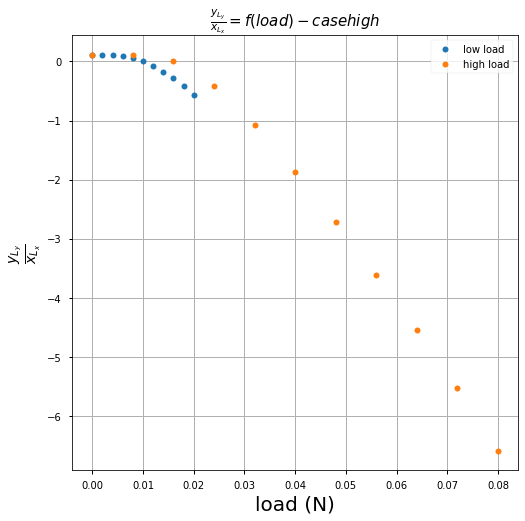

In [21]:
plt.figure(figsize=(8,8))

x_L = displ_low[0,:] + Lx
y_L = displ_low[1,:] + Ly

plt.plot(loading_low, y_L/x_L, '.', markersize=12, label='low load')

plt.title(r'$\frac{y_{L_y}}{x_{L_x}} = f(load)$', size=15)
plt.ylabel(r'$\frac{y_{L_y}}{x_{L_x}}$', size=20)
plt.xlabel('load (N)', size=20)

plt.grid(True)

# -----------

x_L = displ_high[0,:] + Lx
y_L = displ_high[1,:] + Ly

plt.plot(loading_high, y_L/x_L, '.', markersize=12, label='high load')

plt.title(r'$\frac{y_{L_y}}{x_{L_x}} = f(load) - case high$', size=15)
plt.ylabel(r'$\frac{y_{L_y}}{x_{L_x}}$', size=20)
plt.xlabel('load (N)', size=20)

plt.grid(True)

# -----------

plt.legend()

From this graph one can deduce y position as a function of x (at right).

The comparison between low and high loading shows that if one considers a too big loading, the Newton method goes from a value to another with "too big speed". One should increase the number of time step too run calculation on higher loads.

Maybe doesn't converge to same values.

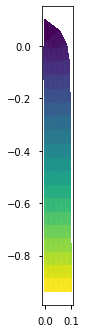

In [22]:
# solve_hyperelasticity(load_max=0.1, nsteps=40, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)
loads, displ, usol = solve_elasticity(load_max=.3, nsteps=40, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)

dolfin.plot(usol, mode = "displacement")

# Exercice
- Try to have energy graph to see when Newton method doesn't converge.
- How the arrow behaves with loading ?
- What difference between KSV and Neo-Hookean ?


- Try to increase the maximum loading to 0.3. Is the Newton solver converging?
- Try to reduce the number of steps to reach the maximum loading. Is the Newton solver converging?
- For low forces, plot y(L)/x(L) versus the force.
- For significant forces, draw the same thing. What are the shapes of the two curves ?
- Try to replace the elastic energy density with the weakly incompressible Neo-Hookean mode where:
$$
\psi(F) = \dfrac{\mu}{2}(\mathrm{tr}(F^T F) - 2) - \mu\ln(\det F) + (\lambda/2)*(\ln(\det F))^2
$$
and perform again the numerical simulation for a loading going form 0 to 0.3. Is now the Newton solver converging? 
- A further *optional* analytical exercice: calculate by analytical derivation for the energy density given above.
    $$P=\dfrac{\partial \psi(F)}{\partial F}$$
    You can find help in a book of nonlinear elasticity. For example, see Sec. 3.5 of *P.Wriggers, Nonlinear Finite Element Methods, Springer*, that you can download legally from your digital library on the monUPMC account.

## II. Weakly incompressible Neo-Hookean mode

In [23]:
# self consistent cell to solve the flexion problem in linearized case.
# the linearisation is used with Newton method and works under a good 
# equilibrium between energy and time steps (e.g. if we consider b0 too big we have too big jump of energy when trying to minimize ???)

# -----------
# Libraries
# -----------

import numpy as np
import matplotlib.pyplot as plt

import dolfin
import ufl

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')

# -----------
#     Code
# -----------

def solve_hyperelasticity_neo(load_max=0.3, nsteps=40, nload=5, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1):
    
    """ Function solving the non-linear flexion of a 2D beam. 
    Entry parameters are initialize to provide a working example."""
    
    # ------
    #  mesh
    # ------

    dim    = 2
    degree = 2
    
    mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(Lx, Ly), nx, ny)
    
    # -----------
    # boundaries
    # -----------
    
    left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
    right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=Lx)
    boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
    
    left_index = 1
    right_index = 2
    
    left.mark(boundary_markers, left_index)
    right.mark(boundary_markers, right_index)
    
    # -------
    
    # Variables weak formulation
    
    ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
    dx = dolfin.dx(domain=mesh)
    
    V_element = dolfin.VectorElement('CG', 
                                     ufl.triangle, 
                                     degree=degree, 
                                     dim=dim)
    
    V  = dolfin.FunctionSpace(mesh, V_element)
    u  = dolfin.Function(V, name="u")
    
    # ---------
    #  Tensors
    # ---------

    I  = ufl.Identity(dim)
    F  = ufl.variable(I + ufl.grad(u))  
    C  = F.T*F                   
    
    # ---------

    Ic = ufl.tr(C)
    J  = ufl.det(F)
    E  = 1/2*(C-I)
    Y  = 1.e3
    
    # -----------------------------------------
    #  weakly incompressible Neo-Hookean mode 
    # -----------------------------------------

    mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
    lmbda     = 2*lmbda*mu/(lmbda + 2*mu) 
    psi_neo   = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2
    
    # --------
    #  Forces
    # --------

    b0    = dolfin.Expression(("0.0", "t*mu"), t=0, mu=mu, degree=0)  
    g0    = mu*dolfin.Constant((0.0,0.0)) 
    
    # ------------------
    #  Weak formulation
    # ------------------

    potential_energy = psi_neo*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(2)
    residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
    jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))
    
    # Solving
    bcs      = [dolfin.DirichletBC(V, (0., 0.), left)]
    problem  = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
    solver   = dolfin.NonlinearVariationalSolver(problem)
    
    # minimize energy / save values
    loads    = np.linspace(load_min, load_max, nload)
    displ    = np.zeros((2, np.size(loads)))
    u.interpolate(dolfin.Constant((0.,0.)))
    file_u   = dolfin.XDMFFile("output/u.xdmf")
    file_u.parameters.update({"flush_output": True,
                              "functions_share_mesh": True,
                              "rewrite_function_mesh": False})
    for (i, t) in enumerate(loads):
        b0.t = -t # downwards gravity force
        solver.solve()
        displ[0, i] = dolfin.assemble(u[1]*ds(2))/Ly
        displ[1, i] = dolfin.assemble(u[0]*ds(2))/Ly
#         print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
        with file_u as file:
            file.write(u, t)
    
#     plt.figure(2)
#     plt.plot(loads, displ, "o")
#     plt.xlabel("load")
#     plt.ylabel("end-displacement")
#     plt.savefig("output/displacement.png")
    
    return (loads, displ, u)

##### Test function

In [24]:
load, disp, u = solve_hyperelasticity_neo(load_max=.2, nsteps=40, nload=20, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)

### $\Rightarrow$ Load step influences a lot the convergence.

### $\Rightarrow$ Look for method to loop and see which couple ($n_{steps}$, $n_{load}$) bring an error.

In [27]:
time_step = np.linspace(20, 0, 21)

for dt in time_step.astype(int):
    print('nb time step=', dt)
    loads, displ, usol = solve_elasticity(load_max=.4, nsteps=dt, nload=15, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1)

nb time step= 20
nb time step= 19
nb time step= 18
nb time step= 17
nb time step= 16
nb time step= 15
nb time step= 14
nb time step= 13
nb time step= 12
nb time step= 11
nb time step= 10
nb time step= 9
nb time step= 8
nb time step= 7
nb time step= 6
nb time step= 5
nb time step= 4
nb time step= 3
nb time step= 2
nb time step= 1
nb time step= 0


Result doesn't look to be influenced by time step but rather by nb of load.

**Is it mandatory to link time steps to nb loads ???
The value of time step should vary with the weight or other ext forces.**

# Neo-Hookean should be better for big deformation